# Adding Particles During Simulation

In this tutorial, we demonstrate how add particles to an aerosol object. This is useful when you want to modify a custom aerosol process during a simulation.

The example is for a particle resolved simulation, the same approach can be used for the other types of particle representations (*but it has not been tested yet*).

**Imports**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# particula imports
from particula.next import particles
from particula.next.aerosol import Aerosol

from particula.next.gas.species_builders import PresetGasSpeciesBuilder
from particula.next.gas.atmosphere_builders import AtmosphereBuilder

## Aerosol Setup

We need to first make the aerosol object. Details on this can be found in the Aerosol Tutorial.

In [2]:
# Preset gas species that does not condense in the atmosphere
# AtmosphereBuilder constructs the atmosphere with predefined species
atmosphere = (
    AtmosphereBuilder()
    .add_species(PresetGasSpeciesBuilder().build())  # Add a preset gas species
    .set_temperature(25, temperature_units="degC")  # Set temperature to 25°C
    .set_pressure(1, pressure_units="atm")  # Set pressure to 1 atmosphere
    .build()  # Finalize the atmosphere object
)

# Generate a particle distribution using a lognormal sample distribution
# This distribution has a mean particle diameter (mode) and geometric standard deviation (GSD)
particle_sample = particles.properties.lognormal_sample_distribution(
    mode=np.array([100e-9]),  # Mean particle diameter of 100 nm
    geometric_standard_deviation=np.array([1.3]),  # GSD of 1.3
    number_of_particles=np.array([1e4]),  # Total number of particles
    number_of_samples=100_000,  # Number of samples for particle distribution
)

# Calculate the mass of each particle in the sample, assuming density of 1500 kg/m^3
particle_mass_sample = (
    4 / 3 * np.pi * particle_sample**3 * 1500
)  # Particle mass in kg

# Build a resolved mass representation for each particle
# This defines how particle mass, activity, and surface are represented
resolved_masses = (
    particles.ResolvedParticleMassRepresentationBuilder()
    .set_distribution_strategy(particles.ParticleResolvedSpeciatedMass())  # Use speciated mass distribution
    .set_activity_strategy(particles.ActivityIdealMass())  # Define activity based on ideal mass
    .set_surface_strategy(particles.SurfaceStrategyVolume())  # Define surface area based on particle volume
    .set_mass(particle_mass_sample, "kg")  # Assign mass of particles (in kg)
    .set_density(1500, "kg/m^3")  # Set particle density to 1500 kg/m^3
    .set_charge(0)  # Assume neutral particles with no charge
    .set_volume(1, "cm^3")  # Set volume of particle distribution
    .build()  # Finalize the resolved mass representation
)

# Create an aerosol object with the defined atmosphere and resolved particles
aerosol = Aerosol(atmosphere=atmosphere, particles=resolved_masses)

# Print the properties of the atmosphere
print(aerosol)

Gas mixture at 298.15 K and 101325.0 Pa consisting of ['Preset100']
[0]: Particle Representation:
	Strategy: ParticleResolvedSpeciatedMass
	Activity: ActivityIdealMass
	Surface: SurfaceStrategyVolume
	Mass Concentration: 8.605e-07 [kg/m^3]
	Number Concentration: 1.000e+11 [#/m^3]


## Particles to Add

For the particle resolved representation, the particles to add must be the provide an array of new particle masses and the concentrations. 

Currently the concentrations should all be one, as this is the particle resolved representation.

If you have multiple species, then the shape of the `added_distribution` should be `(number of particles, number of species)`. But `added_concentration` is still `(number of particles,)`.

In [3]:
# particles to add

# Generate a particle distribution using a lognormal sample distribution
# This distribution has a mean particle diameter (mode) and geometric standard deviation (GSD)
particles_to_add = particles.properties.lognormal_sample_distribution(
    mode=np.array([1e-9]),  # Mean particle diameter of 100 nm
    geometric_standard_deviation=np.array([1.1]),  # GSD of 1.3
    number_of_particles=np.array([1e4]),  # Total number of particles
    number_of_samples=10_000,  # Number of samples for particle distribution
)

# Calculate the mass of each particle in the sample, assuming density of 1500 kg/m^3
particle_mass_add = (
    4 / 3 * np.pi * particles_to_add**3 * 1500
)  # Particle mass in kg
concentration_add = np.ones_like(particle_mass_add)


# print shapes
print(f"Particles to add: {particle_mass_add.shape}")


Particles to add: (10000,)


In [4]:
# Get initial particle radii before adding particle
initial_radii = aerosol.particles[0].get_radius(clone=True)
print(f"Initial concentration: {aerosol.particles[0].get_total_concentration()}")

# Perform the add process
aerosol.particles[0].add_concentration(  # select the particle representation and call add_concentration
    added_concentration=concentration_add,
    added_distribution=particle_mass_add,
)
radii_after_step_1 = aerosol.particles[0].get_radius(clone=True)
print(f"Concentration after step 1: {aerosol.particles[0].get_total_concentration()}")

# Perform the add process
aerosol.particles[0].add_concentration(
    added_concentration=concentration_add,
    added_distribution=particle_mass_add,
)
radii_after_step_2 = aerosol.particles[0].get_radius(clone=True)

print(f"Concentration after step 2: {aerosol.particles[0].get_total_concentration()}")
concentration_value = aerosol.particles[0].concentration

Initial concentration: 99999999999.99998
Concentration after step 1: 109999999999.99998
Concentration after step 2: 119999999999.99998


## Graphing

We now visualize the two particle add steps

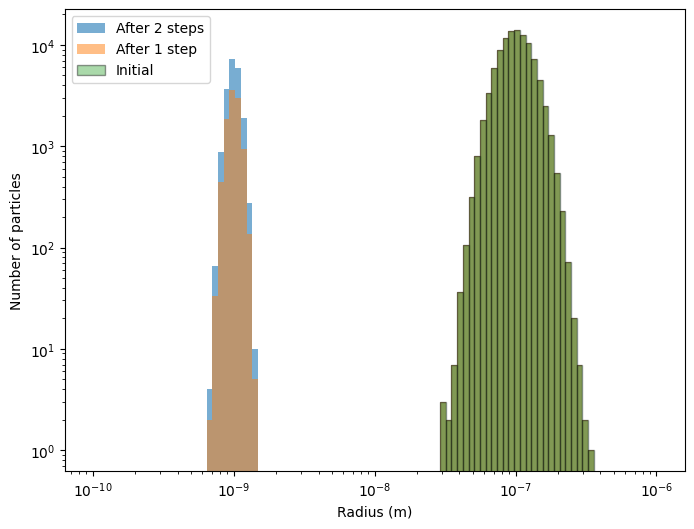

In [5]:
# Define lognormal bins for particle radius histogram
bins_lognormal = np.logspace(-10, -6, 100)

# Create figure for visualizing the histogram of particle radii
fig, ax = plt.subplots(figsize=(8, 6))

# Plot radii distribution after step 2
bins, edges = np.histogram(radii_after_step_2, bins=bins_lognormal)
ax.bar(
    edges[:-1],
    bins,
    width=np.diff(edges),
    align="edge",
    label="After 2 steps",
    alpha=0.6,
)
# Plot radii distribution after step 1

bins, edges = np.histogram(radii_after_step_1, bins=bins_lognormal)
ax.bar(
    edges[:-1],
    bins,
    width=np.diff(edges),
    align="edge",
    label="After 1 step",
    alpha=0.5,
)

# Plot initial radii distribution
bins, edges = np.histogram(initial_radii, bins=bins_lognormal)
ax.bar(
    edges[:-1],
    bins,
    width=np.diff(edges),
    align="edge",
    label="Initial",
    alpha=0.4,
    edgecolor="black")

# Set axes to logarithmic scale for x-axis (particle radius)
ax.set_xscale("log")
ax.set_yscale("log")

# Add labels and legend
ax.set_xlabel("Radius (m)")
ax.set_ylabel("Number of particles")
plt.legend()

# Show the plot
plt.show()

## Conclusion

We have demonstrated how to add particles to an aerosol object. This is useful when you want to modify a aerosol object with a custom process during a simulation.